### Imports

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import random
import shutil
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf

c:\Users\gael8\anaconda3\envs\ml\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Create Directories

In [2]:
IMAGE_FOLDER = "../tusimple_processed/images"
MASK_FOLDER = "../tusimple_processed/masks"

In [3]:
def create_directories_if_not_exists(dir_path):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print("Directory created:", dir_path)
    else:
        print("Directory already exists:", dir_path)

In [4]:
shutil.rmtree(MASK_FOLDER)
shutil.rmtree(IMAGE_FOLDER)
create_directories_if_not_exists(IMAGE_FOLDER)
create_directories_if_not_exists(MASK_FOLDER)

Directory created: ../tusimple_processed/images
Directory created: ../tusimple_processed/masks


### Copy Images to the Image Directory

In [5]:
CLIPS_PATH = "../data/tusimple/versions/5/TUSimple/train_set/clips"

# iterate through each directory
for clip_dir in os.listdir(CLIPS_PATH):
    clip_dir_path = os.path.join(CLIPS_PATH, clip_dir)

    print("Processing clip:", clip_dir)
    # iterate through each sub directory
    for frame_dir in os.listdir(clip_dir_path):
        frame_path = os.path.join(clip_dir_path, frame_dir, "20.jpg")

        # check if file is present
        if not os.path.isfile(frame_path):
            continue

        # create new file name based on last 2 directory names
        temp = frame_path[:-7].split("\\")[-2:]      
        new_filename = f"{temp[0]}_{temp[1]}.jpg"
        file_file_path = os.path.join(IMAGE_FOLDER, new_filename)

        # copy the file
        shutil.copy(frame_path, file_file_path)

Processing clip: 0313-1
Processing clip: 0313-2
Processing clip: 0531
Processing clip: 0601


In [6]:
print("Total images in dataset:", len(os.listdir(IMAGE_FOLDER)))

Total images in dataset: 3626


### Create Masks for the Images 

In [7]:
# load the dataset json files
df1 = pd.read_json("../data/tusimple/versions/5/TUSimple/train_set/label_data_0313.json", lines=True)
df2 = pd.read_json("../data/tusimple/versions/5/TUSimple/train_set/label_data_0531.json", lines=True)
df3 = pd.read_json("../data/tusimple/versions/5/TUSimple/train_set/label_data_0601.json", lines=True)

# combine into single dataframe
df = pd.concat([df1, df2, df3])
df.head()

,lanes,h_samples,raw_file
0,"[[-2, -2, -2, -2, 632, 625, 617, 609, 601, 594...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-1/6040/20.jpg
1,"[[-2, -2, -2, 658, 646, 635, 623, 612, 601, 58...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-1/5320/20.jpg
2,"[[-2, 570, 554, 538, 522, 505, 489, 473, 456, ...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-1/23700/20.jpg
3,"[[-2, -2, -2, -2, 555, 542, 530, 517, 505, 493...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-1/51660/20.jpg
4,"[[-2, -2, -2, 522, 525, 528, 531, 534, 537, 53...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-1/25680/20.jpg


In [8]:
# create function for generating masks
def generate_lane_masks(row):
    # create a mask of all zeros
    mask = np.zeros((720, 1280), dtype=np.uint8)

    # extract data from the row
    h_samples = row.h_samples
    lanes = row.lanes
    raw_file = row.raw_file

    # create masks: lane = 1 (white), non-lane = 0 (black)
    for lane in lanes:
        # filter out invalid points (-2) and create coordinate pairs
        valid_points = [(x, y) for x, y in zip(lane, h_samples) if x != -2]
        
        # only draw if we have at least 2 points for a line
        if len(valid_points) >= 2:
            lane_points = np.array(valid_points)
            cv2.polylines(mask, [lane_points], isClosed=False, color=(255, 255, 255), thickness=5)

    # generate mask file name
    temp = raw_file[:-7].split("/")[-2:]
    mask_filename = f"{temp[0]}_{temp[1]}.jpg"
    mask_filename_path = os.path.join(MASK_FOLDER, mask_filename)

    # write the mask image
    cv2.imwrite(mask_filename_path, mask)


In [9]:
# generate masks
for index, row in tqdm(df.iterrows(), total=len(df)):
    generate_lane_masks(row)

100%|██████████| 3626/3626 [00:13<00:00, 264.65it/s]


In [10]:
print("Total masks in dataset:", len(os.listdir(MASK_FOLDER)))

Total masks in dataset: 3626


### Data Visualization

In [11]:
def visualize_image(image_name):
    # get paths
    image_path = os.path.join(IMAGE_FOLDER, image_name)
    
    mask_path = os.path.join(MASK_FOLDER, image_name)    
    
    # read the image and mask
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path)

    # plot the image
    plt.figure(figsize=(20, 8))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Road Image")

    # plot the mask
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.title("Ground Truth Mask")

    # show the plot
    plt.show()

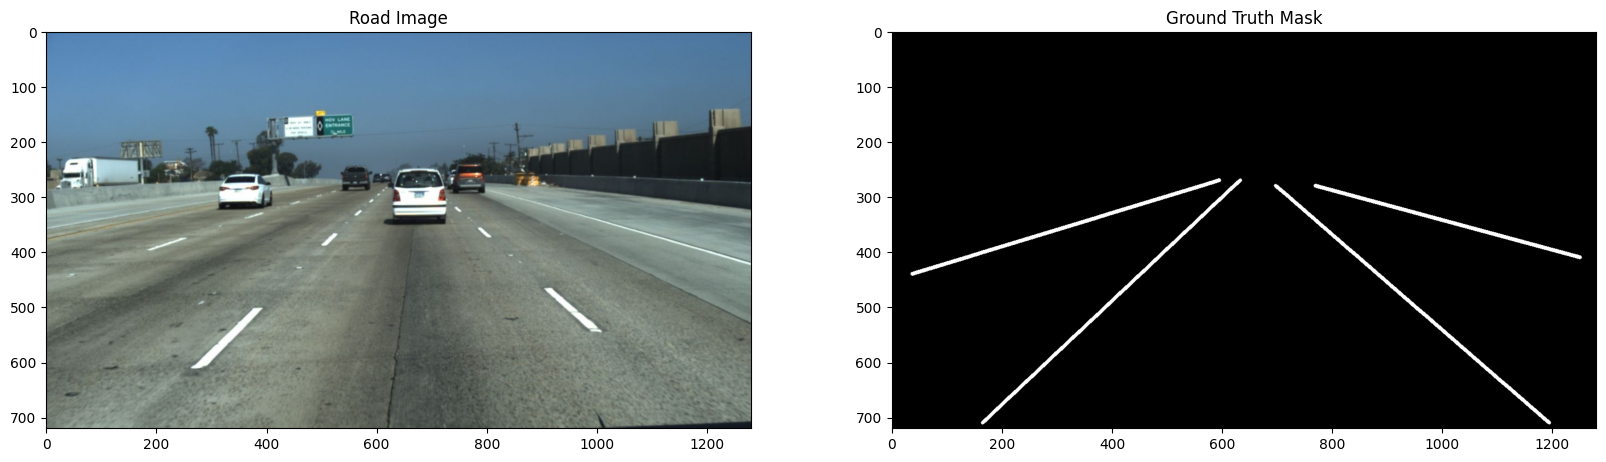

In [12]:
image_name = random.choice(os.listdir(IMAGE_FOLDER))
visualize_image(image_name)

### Process data for training and testing

In [13]:
train_image_folder = "../tusimple_processed/train/images"
test_image_folder = "../tusimple_processed/test/images"

train_mask_folder = "../tusimple_processed/train/masks"
test_mask_folder = "../tusimple_processed/test/masks"

In [14]:
for folder_path in [train_image_folder, test_image_folder, train_mask_folder, test_mask_folder]:
    create_directories_if_not_exists(folder_path)

Directory already exists: ../tusimple_processed/train/images
Directory already exists: ../tusimple_processed/test/images
Directory already exists: ../tusimple_processed/train/masks
Directory already exists: ../tusimple_processed/test/masks


In [15]:
from sklearn.model_selection import train_test_split
images = [file for file in os.listdir(IMAGE_FOLDER) if file.endswith(".jpg")]
masks = [file for file in os.listdir(MASK_FOLDER) if file.endswith(".jpg")]

# split for train and test
train_images, test_images = train_test_split(images, test_size = 0.1, random_state = 42)

In [16]:
len(train_images), len(test_images)

(3263, 363)

In [17]:
# move files to corresponding folders
for file in train_images:
    # move the image and mask
    source = os.path.join(IMAGE_FOLDER, file)
    destination = os.path.join(train_image_folder, file)
    shutil.move(source, destination)

    source = os.path.join(MASK_FOLDER, file)
    destination = os.path.join(train_mask_folder, file)
    shutil.move(source, destination)

for file in test_images:
    # move the image and mask
    source = os.path.join(IMAGE_FOLDER, file)
    destination = os.path.join(test_image_folder, file)
    shutil.move(source, destination)

    source = os.path.join(MASK_FOLDER, file)
    destination = os.path.join(test_mask_folder, file)
    shutil.move(source, destination)

### Feature Engineering

In [18]:
def load_image(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3) # cus rgb
    image = tf.image.resize(image, [256, 256])
    image = image/255.0 # normalize to [0, 1]

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=1) # cus grayscale
    mask = tf.image.resize(mask, [256, 256])
    mask = mask/255.0 # normalize to [0, 1]

    return image, mask

def dataset_from_folder(image_folder, mask_folder):
    image_files = sorted([os.path.join(image_folder, file) for file in os.listdir(image_folder) if file.endswith(".jpg")])
    masks_files = sorted([os.path.join(mask_folder, file) for file in os.listdir(mask_folder) if file.endswith(".jpg")])

    dataset = tf.data.Dataset.from_tensor_slices((image_files, masks_files))
    dataset = dataset.map(lambda image_path, mask_path: load_image(image_path, mask_path))
    return dataset

In [19]:
# laod dataset from folder
train_dataset = dataset_from_folder(train_image_folder, train_mask_folder)
test_dataset = dataset_from_folder(test_image_folder, test_mask_folder)

In [20]:
# set config
BATCH_SIZE = 32
BUFFER_SIZE = 1000

# optimize for performance improvement
train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [21]:
def display_sample(image_list):
    plt.figure(figsize=(10, 10))

    titles = ["Image", "True Mask", "Predicted Mask"]

    for i in range(len(image_list)):
        plt.subplot(1, len(image_list), i+1)
        plt.title(titles[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image_list[i]))
        plt.axis("off") # no axis
        
    plt.show()

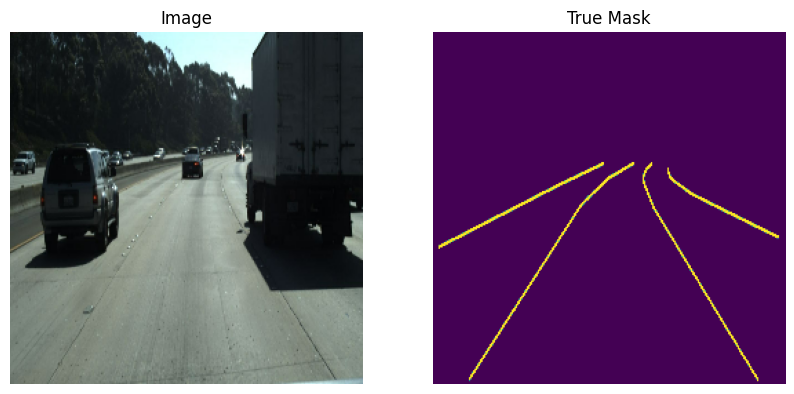

In [22]:
for image, mask in train_dataset.take(1):
    display_sample([image[0], mask[0]])

### Model Creation - VGG-UNet

In [23]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Dropout, Activation, Add, BatchNormalization, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, UpSampling2D
from tensorflow.keras.models import Model

def VGG_UNet(input_shape=(256, 256, 3)):
    """
    UNet architecture with VGG16 encoder (down/up sampling with skip architecture)
    """
    def Con2DReluBatchNorm(n_filters, kernel_size, strides, inputs):
        x = Conv2D(n_filters, (1,1), strides=1, padding="same", kernel_initializer="glorot_normal", activation="elu")(inputs)
        x = Conv2D(n_filters, kernel_size, strides=strides, padding="same", kernel_initializer="glorot_normal", activation="elu")(x)

        x = BatchNormalization()(x)
        x = Dropout(rate=0.25)(x, training=True) # training + test-time dropout!
        return x

    # VGG16 encoder
    vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)

    # unfreeze VGG16 layers
    for layer in vgg16.layers:
        layer.trainable = True
    
    # encode layers
    inputs = vgg16.input
    layer_1 = vgg16.get_layer("block1_conv2").output
    layer_2 = vgg16.get_layer("block2_conv2").output
    layer_3 = vgg16.get_layer("block3_conv3").output
    layer_4 = vgg16.get_layer("block4_conv3").output
    layer_5 = vgg16.get_layer("block5_conv3").output

    # decoder layers
    merge6 = Concatenate(axis=-1)([UpSampling2D(size=(2,2))(layer_5), layer_4])
    layer_6 = Con2DReluBatchNorm(512, (3, 3), (1, 1), merge6)

    merge7 = Concatenate(axis=-1)([UpSampling2D(size=(2,2))(layer_6), layer_3])
    layer_7 = Con2DReluBatchNorm(256, (3, 3), (1, 1), merge7)

    merge8 = Concatenate(axis=-1)([UpSampling2D(size=(2,2))(layer_7), layer_2])
    layer_8 = Con2DReluBatchNorm(128, (3, 3), (1, 1), merge8)

    merge9 = Concatenate(axis=-1)([UpSampling2D(size=(2,2))(layer_8), layer_1])
    layer_9 = Con2DReluBatchNorm(64, (3, 3), (1, 1), merge9)

    output = Conv2D(1, (1,1), strides=1, activation="sigmoid", name="output")(layer_9)

    return Model(inputs=inputs, outputs=output)

model = VGG_UNet(input_shape=(256, 256, 3)) # adjust input shape as needed, we used 256x256 earlier

In [24]:
import tensorflow
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred):
    y_true_f=K.flatten(y_true)
    mu     = y_pred[:,:,:,0]
    y_pred_f=K.flatten(mu)
    intersection=K.sum(y_true_f*y_pred_f)
    smooth=1.0
    return (2*intersection+smooth) / (K.sum(y_true_f)+K.sum(y_pred_f)+smooth)

def dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def recall_smooth(y_true, y_pred):
    y_pred_f=K.flatten(y_pred)
    y_true_f=K.flatten(y_true)
    intersection=K.sum(y_true_f*y_pred_f)
    return (intersection / (K.sum(y_true_f) + K.epsilon()))

def precision_smooth(y_true, y_pred):
    y_pred_f=K.flatten(y_pred)
    y_true_f=K.flatten(y_true)
    intersection=K.sum(y_true_f*y_pred_f)
    return (intersection / (K.sum(y_pred_f) + K.epsilon()))

def accuracy(y_true, y_pred):
    y_pred_f=K.flatten(y_pred)
    y_true_f=K.flatten(y_true)

    # true positives
    true_positives = K.sum(K.round(K.clip(y_true_f * y_pred_f, 0, 1)))

    # true negatives
    true_negatives = K.sum(K.round(K.clip((1-y_true_f) * (1-y_pred_f), 0, 1)))

    # total pixels
    total_pixels = K.cast(tensorflow.size(y_true_f), K.floatx())

    # accuracy
    accuracy_value = (true_positives + true_negatives) / total_pixels

    return accuracy_value

In [25]:
# compile the model
model.compile(optimizer="adam", loss=dice_loss, metrics=[dice_coef, recall_smooth, precision_smooth, accuracy])
print("Number of parameters:", model.count_params())

Number of parameters: 18636289


In [30]:
# plot the model
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True, dpi=64)

You must install pydot (`pip install pydot`) for `plot_model` to work.
